Using device: cpu
Loading MiDaS model...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


🚀 AI-Powered Parallax Effect Generator 🚀
----------------------------------------

STEP 1: Upload your image (JPEG/PNG)


Saving cube2.jpeg to cube2 (1).jpeg

Generating AI depth map...

Enter shift amount (1-50, default 15): 40
Creating parallax effect with shift amount 40...


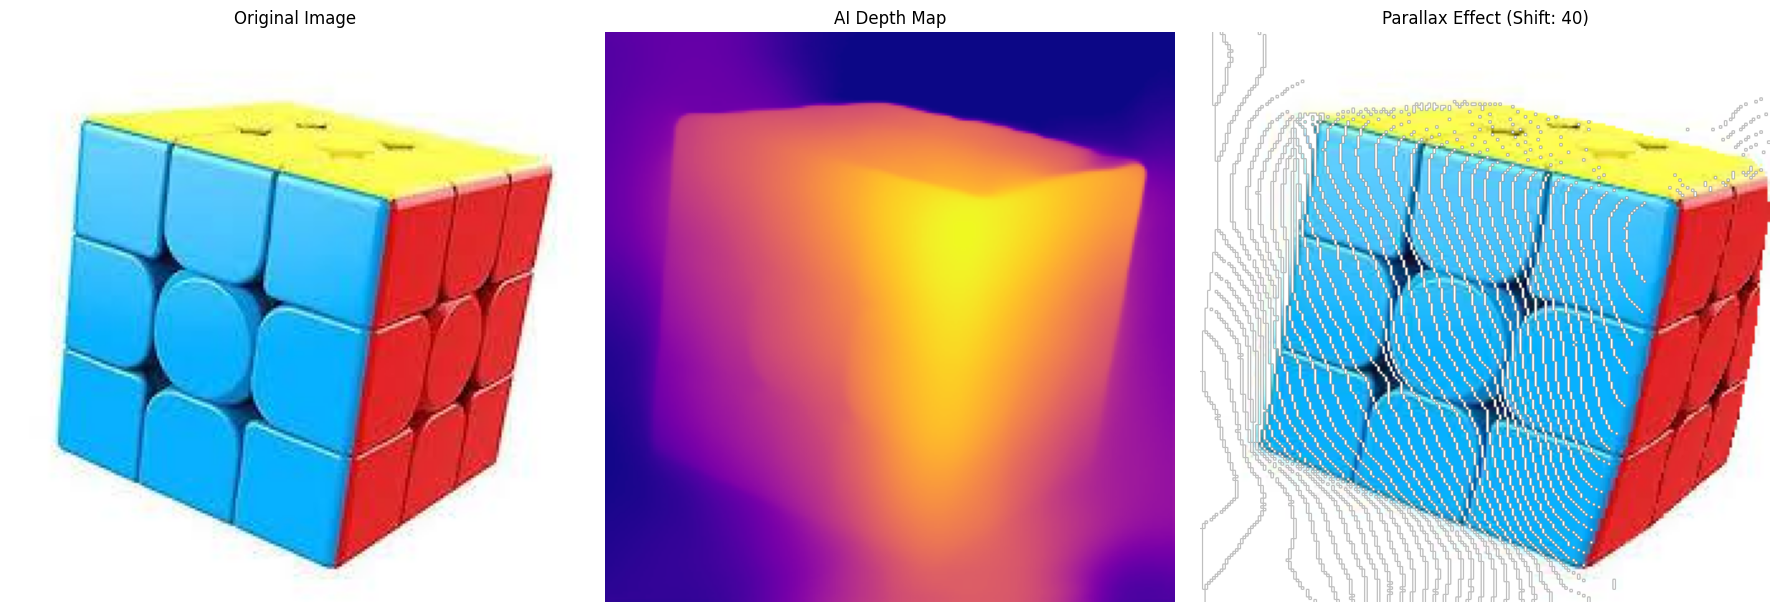

In [2]:
from PIL import Image
import numpy as np
from google.colab import files
import io
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# First install required packages
!pip install -q torch torchvision opencv-python-headless

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MiDaS model (small version for faster processing)
print("Loading MiDaS model...")
model = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small').to(device)
model.eval()

# Image transformation for MiDaS
midas_transform = Compose([
    Resize((384, 384)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def generate_depth_map(img):
    """Generate depth map using MiDaS model"""
    if img.mode != 'RGB':
        img = img.convert('RGB')

    input_tensor = midas_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        depth = model(input_tensor)

    depth = depth.squeeze().cpu().numpy()
    depth_norm = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
    depth_norm = np.uint8(depth_norm)
    depth_norm = cv2.resize(depth_norm, img.size)

    return Image.fromarray(depth_norm)

def shift_image(img, depth_img, shift_amount=15):
    """Create parallax effect by shifting pixels based on depth"""
    img = img.convert("RGBA")
    data = np.array(img)

    depth_img = depth_img.convert("L")
    depth_data = np.array(depth_img)
    deltas = ((depth_data / 255.0) * float(shift_amount)).astype(int)

    shifted_data = np.zeros_like(data)
    height, width, _ = data.shape

    for y, row in enumerate(deltas):
        for x, dx in enumerate(row):
            new_x = x + dx
            if 0 <= new_x < width:
                shifted_data[y, new_x] = data[y, x]

    return Image.fromarray(shifted_data.astype(np.uint8))

def main():
    print("🚀 AI-Powered Parallax Effect Generator 🚀")
    print("----------------------------------------")

    # Upload base image
    print("\nSTEP 1: Upload your image (JPEG/PNG)")
    uploaded = files.upload()
    while not uploaded:
        print("No file uploaded. Please try again.")
        uploaded = files.upload()

    img = Image.open(io.BytesIO(uploaded[next(iter(uploaded))]))

    # Generate depth map
    print("\nGenerating AI depth map...")
    depth_img = generate_depth_map(img)

    # Get shift amount from user
    while True:
        try:
            shift_amount = int(input("\nEnter shift amount (1-50, default 15): ") or 15)
            if 1 <= shift_amount <= 50:
                break
            else:
                print("Please enter a value between 1 and 50")
        except ValueError:
            print("Please enter a valid number")

    # Create parallax effect
    print(f"Creating parallax effect with shift amount {shift_amount}...")
    result = shift_image(img, depth_img, shift_amount)

    # Save outputs
    result.save("parallax_effect.png")
    depth_img.save("depth_map.png")

    # Display results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(depth_img, cmap='plasma')
    plt.title("AI Depth Map", fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title(f"Parallax Effect (Shift: {shift_amount})", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Download links
    display(HTML('''
    <div style="margin: 20px; padding: 15px; border: 1px solid #ddd; border-radius: 5px;">
        <h3 style="margin-top: 0;">Download Results:</h3>
        <ul style="padding-left: 20px;">
            <li><a href="parallax_effect.png" download style="color: #1a73e8; text-decoration: none;">✨ Parallax Effect Image</a></li>
            <li><a href="depth_map.png" download style="color: #1a73e8; text-decoration: none;">🗺️ Depth Map</a></li>
        </ul>
        <p style="font-style: italic; color: #666;">Tip: Wiggle the parallax image to see the 3D effect</p>
    </div>
    '''))

if __name__ == "__main__":
    main()